In [1]:
#@title Run to setup question dependencies
!pip install --upgrade -q tfds-nightly tensorflow-addons

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 22.6 MB/s 


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


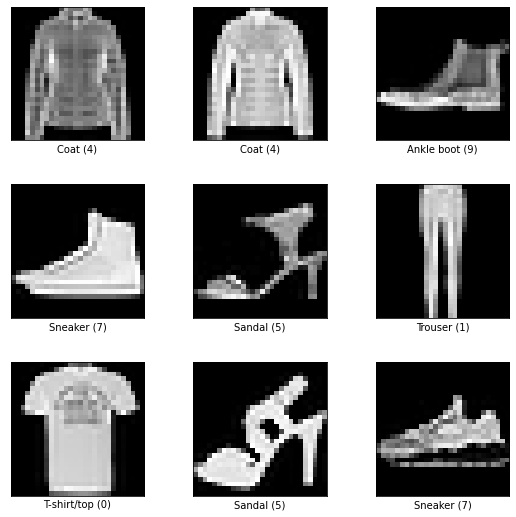

In [2]:
#@title Run to download and prepare dataset
#@markdown - https://www.tensorflow.org/datasets/catalog/fashion_mnist

import tensorflow as tf
import tensorflow_datasets as tfds

(__DS_TRAIN, __DS_TEST), __DS_INFO = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

_ = tfds.show_examples(__DS_TEST, __DS_INFO)

# Prepare splits
def __normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label
# Prepare train split
__DS_TRAIN = __DS_TRAIN.map(__normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
__DS_TRAIN = __DS_TRAIN.cache()
__DS_TRAIN = __DS_TRAIN.shuffle(__DS_INFO.splits['train'].num_examples)
__DS_TRAIN = __DS_TRAIN.batch(128)
__DS_TRAIN = __DS_TRAIN.prefetch(tf.data.experimental.AUTOTUNE)
# Prepare test split
__DS_TEST = __DS_TEST.map(__normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
__DS_TEST = __DS_TEST.batch(128)
__DS_TEST = __DS_TEST.cache()
__DS_TEST = __DS_TEST.prefetch(tf.data.experimental.AUTOTUNE)

In [3]:
#@title Run to setup model genome processing code
#@markdown A model genome is a string having `;` seperated parts where each part describes a specific layer.
#@markdown 
#@markdown For eg., this cell genome has 1 normal convolution layer followed by 2 reduction convolution layers and relu activation in the final layer.
#@markdown ```
#@markdown NC 10 2 sigmoid;RC 10 3 relu;RC 10 3 relu;FL relu;
#@markdown ```
#@markdown 
#@markdown In the above example the normal layer has 10 CNN filters having a kernel size of 2 and sigmoid activation. After the normal layer it has 2 reduction layers with 10 filters, kernel size of 3 and relu activation function. This example therefore has 3 internal layers. Finally, the genome specifies `relu` activation for the final layer(FL).
#@markdown 
#@markdown The format for each genome part for `NC` and `RC` layers is as follows,
#@markdown ```
#@markdown <NC or RC> <no. of CNN filters> <kernel size LESS THAN 8> <activation function>;
#@markdown ```
#@markdown After all `NC` and `RC` genome parts the final layer genome part has the following format,
#@markdown ```
#@markdown FL <activation function>;
#@markdown ```
#@markdown With the above, the full genome format is,
#@markdown ```
#@markdown <any number of FC/RC genome parts>;FL <activation function>;
#@markdown ```
#@markdown Here,
#@markdown - `NC` is normal genome and `RC` is reduction genome. Normal genomes keep the dimentions of the input image intact (i.e. `stride=1`), while reduction genomes make the output image dimension half of the input dimension.
#@markdown  - See the constraints section above for specific details.
#@markdown - Every genome **MUST** have **EXACTLY 2** `RC` parts. These `RC` parts can be placed anywhere in the genome.

import tensorflow as tf
import tensorflow_addons as tfa
import re
from collections import Counter

__ALLOWED_ACTIVATIONS = [
                         'relu',
                         'sigmoid',
                         'tanh',
                         'swish',
                         'gelu',
]
__VALIDATION_RE_CELL = re.compile(f'((?P<type>NC|RC) (?P<filters>\d+?) (?P<kernel>[1234567]) (?P<activation>{"|".join(__ALLOWED_ACTIVATIONS)});)+?')
__VALIDATION_RE_FL = re.compile(f'FL (?P<fl_activation>{"|".join(__ALLOWED_ACTIVATIONS)});')
__VALIDATION_RE = re.compile(f'((?P<type>NC|RC) (?P<filters>\d+?) (?P<kernel>[1234567]) (?P<activation>{"|".join(__ALLOWED_ACTIVATIONS)});)+?FL (?P<fl_activation>{"|".join(__ALLOWED_ACTIVATIONS)});')

__SAMPLE_GENOME = 'NC 1 1 sigmoid;RC 2 3 relu;RC 5 7 relu;'

def parse_genome(cellgenome: str):
  if __VALIDATION_RE.fullmatch(cellgenome) is None:
    raise Exception(f'Invalid genome (parse error): {cellgenome}\n Please check that the genome is in the correct format.')
  parse = __VALIDATION_RE_CELL.findall(cellgenome)
  # check constraints
  type_count = Counter()
  for idx, cell in enumerate(parse):
    type_count.update([cell[1]])
    filter = int(cell[2])
    kernel = int(cell[3])
    if filter < 1:
      raise Exception(f'Invalid filter size {filter} for layer {idx+1}.')
    if kernel < 1 or kernel > 7:
      raise Exception(f'Invalid kernel size {filter} for layer {idx+1}.')
  if type_count['RC'] != 2:
    raise Exception(f'Genome must have exacly 2 RC parts. Your genome has {type_count["RC"]} RC parts.')
  return parse + __VALIDATION_RE_FL.findall(cellgenome)

def genome_to_model(cellgenome: str, lr: float = 2e-3, lr_decay: float = 0.05):
  # parse genome
  parsed = parse_genome(cellgenome)
  def _match_to_layer(match_tuple, idx):
    return tf.keras.layers.Conv2D(
        filters = int(match_tuple[2]),
        kernel_size = int(match_tuple[3]),
        strides = 1 if match_tuple[1] == 'NC' else 2,
        name = f'Layer_{idx}_{match_tuple[1]}',
        activation = match_tuple[4],
        padding = 'same' if match_tuple[1] == 'NC' else 'valid',
    )
  # create model object
  model = tf.keras.Sequential(
    [
      *[_match_to_layer(cell, idx) for idx, cell in enumerate(parsed[:-1])],
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(
          64,
          activation=parsed[-1],
      ),
      tf.keras.layers.Dense(
          __DS_INFO.features['label'].num_classes,
          activation=parsed[-1],
      ),
    ]
  )
  # compile the model
  model.compile(
      optimizer=tfa.optimizers.AdamW(
          learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=len(__DS_TRAIN)*10,
            decay_rate=lr_decay,
          ),
          weight_decay=1e-9,
      ),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
  )
  model.build((None, *__DS_INFO.features['image'].shape))
  return model

In [13]:
#@title Use this form to validate a genome and see the resulting model
#@markdown Enter your genome in this text field and then run this cell.
__fr_model_genome = "NC 16 6 relu;RC 64 3 tanh;RC 64 3 tanh;FL sigmoid;" #@param {type:"string"}

try:
  __fr_model = genome_to_model(__fr_model_genome)
  __fr_model.summary()
  del __fr_model
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 16)        592       
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 64)        9280      
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 64)          36928     
                                                                 
 global_average_pooling2d_7   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 10)                650       
                                                      

In [6]:
#@title Run to setup model training code
#@markdown You are provided with two functions,
#@markdown - **`get_model_parameters(model_genome: str)`**: This function accepts the model genome string and returns the number of parameters that the model will have. You can use this function to query for the number of parameters without training the model entirely.
#@markdown 
#@markdown    **Returns**: A single integer representing the number of parameters in the model.

#@markdown - **`train_model(model_genome: str, verbose: int = 1, lr: float = None, lr_decacy: float = None)`**: This function accepts the model genome string and trains the model on the Fashion-MNIST dataset. You must use this function to train models based on your genome string.
#@markdown 
#@markdown      - If `verbose` is `0` then this function does not print anything while training
#@markdown      - If `verbose` is `1` then it prints the training progess on each call and the final test accuracy.
#@markdown      - If `verbose` is `2` then it prints everything from `varbose=1` and also prints the model summary (structure).
#@markdown 
#@markdown  It accepts a learning rate (`lr`) and a learning rate exponential decay rate (`lr_decay`). You do not need to provide values for `lr` and `lr_decay`, the default values are tuned to give good performance  3~10 layer networks. Below you will find some example values for a sample shallow network and a sample deep network.
#@markdown 
#@markdown   **Returns**: A tuple of `(test accuracy, train accuracy, number of parameters)`.
#@markdown 
#@markdown Using the above two functions you must create a search method to search for a model genome which gives the maximum **test accuracy**. You are given the train accuracy to identify _overfitting_ if you wish to do so. You can also use the number of parameters to prefer models having fewer parameters and find a good balance between test accuracy and number of parameters.

def get_model_parameters(modelgenome: str):
  '''
  Returns the number of parameters that this genome creates.
  '''
  model = genome_to_model(modelgenome)
  return model.count_params()

def train_model(modelgenome: str, verbose: int = 1, lr: float = None, lr_decay: float = None):
  '''
  Accepts a genome string and trains the corresponding model on Fashion MNIST dataset.
  Thorws exceptions if the provided genome is invalid.
  Returns a tuple: (test accuracy, train accuracy, number of parameters)
  '''
  model = genome_to_model(modelgenome, lr=lr, lr_decay=lr_decay)
  n_params = model.count_params()
  if verbose > 0:
    print(f'Training genome: {modelgenome}')
    print(f'Model params: {n_params}')
  if verbose > 1:
    model.summary()
  # train model
  callbacks = [
    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      mode='min',
      baseline=10.0,
      patience=2,
      min_delta=0.005,
      verbose=verbose,
    )
  ]
  if verbose > 0:
    callbacks.append(
      tfa.callbacks.TQDMProgressBar(
        update_per_second = 1,
        leave_epoch_progress = verbose > 1,
        leave_overall_progress = verbose > 1,
      )
    )
  ret = model.fit(
      __DS_TRAIN,
      epochs=10,
      verbose=0,
      callbacks=callbacks,
      validation_data=__DS_TEST,
  )
  # delete model
  del model
  # get best history
  best_idx = max(range(len(ret.history['val_accuracy'])), key=ret.history['val_accuracy'].__getitem__)
  best_history = {
      k: v[best_idx] for k, v in ret.history.items()
  }
  if verbose > 0:
    print(f'Best test accuracy: {best_history["val_accuracy"]}')
  return (best_history['val_accuracy'], best_history['accuracy'], n_params)

In [14]:
#@title Use this form to train specific genomes
#@markdown Enter your genome in this text field and then run this cell.
#@markdown 
__fr_model_genome = "NC 16 6 relu;RC 64 3 tanh;RC 64 3 tanh;FL sigmoid;" #@param {type:"string"}

#@markdown You can finetune training hyperparameters here, (given values are good defaults and you shouldn't have to change for good results)
__fr_lr = 1e-3 #@param {type:"number"}
__fr_lr_decay = 0.1 #@param {type:"number"}

try:
  # Train
  print('Return value:', train_model(__fr_model_genome, verbose=2, lr=__fr_lr, lr_decay=__fr_lr_decay))
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')

Training genome: NC 16 6 relu;RC 64 3 tanh;RC 64 3 tanh;FL sigmoid;
Model params: 51610
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 16)        592       
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 64)        9280      
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 64)          36928     
                                                                 
 global_average_pooling2d_8   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (No

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8105000257492065
Return value: (0.8105000257492065, 0.8129666447639465, 51610)


In [7]:
#@title Deep model genome example
#@markdown Enter your genome in this text field and then run this cell.
#@markdown 
__fr_model_genome = "NC 16 6 relu;RC 64 3 tanh;RC 64 3 tanh;FL sigmoid;" #@param {type:"string"}

#@markdown You can finetune training hyperparameters here, (given values are good defaults and you shouldn't have to change for good results)
__fr_lr = 1e-3 #@param {type:"number"}
__fr_lr_decay = 0.1 #@param {type:"number"}

try:
  # Train
  print('Return value:', train_model(__fr_model_genome, verbose=2, lr=__fr_lr, lr_decay=__fr_lr_decay))
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')

Training genome: NC 16 6 relu;RC 64 3 tanh;RC 64 3 tanh;FL sigmoid;
Model params: 51610
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 16)        592       
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 64)        9280      
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 64)          36928     
                                                                 
 global_average_pooling2d_2   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (No

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8184000253677368
Return value: (0.8184000253677368, 0.8183833360671997, 51610)


## We have not used the above code snippet provided for data downloading. Instead of this we have directly downloaded dataset from keras and used standard splitting of train(60000) and test(10000)

In [1]:
  #### import libraries

from keras import datasets
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras import layers
from keras import models
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout,GlobalAveragePooling2D
from random import choice
from random import uniform      
import numpy as np
from numpy.random import randint

In [8]:
### load dataset
from keras import datasets
import tensorflow as tf 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


4431872/4422102 [==============================] - 0s 0us/step


In [9]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [10]:
x_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [ ]:
 ###### optional for no gpu
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [3]:
###### Taking image input

''' Images are in raw format and needs to pre-processed'''

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
## reshape
im_train =x_train.astype('float32')/255   ##### normalise between 0-1
im_test=x_test.astype('float32')/255  

####### category conversion  converting number of classes into suitable vectors

class_train=to_categorical(y_train) 
class_test=to_categorical(y_test)

'''This is the standard split 60000-> train and 10000-> test'''

ParImg=im_train         #x_train(60000)
ParClass=class_train    #y_train(10000)

In [4]:
##### CNN architecture as given in problem statement

def architecture( first_filt, second_filt, third_filt, ker1, ker2, trigger1, trigger2, opt, ErlStop):
  pattren = models.Sequential()
#### 2 NC layers (any number of NC layers)
  pattren.add(layers.Conv2D(filters = first_filt, kernel_size = (ker1, ker1), activation = trigger1,strides=(1,1),padding='SAME', input_shape = (28,28,1)))
  pattren.add(layers.Conv2D(filters = first_filt, kernel_size = (ker1, ker1), activation = trigger2,strides=(1,1),padding='SAME'))
#### 2 RC layers
  pattren.add(layers.Conv2D(filters = second_filt, kernel_size = (ker2, ker2), activation = trigger2,strides=(2,2),padding='VALID'))
  pattren.add(layers.Conv2D(filters = second_filt, kernel_size = (ker2, ker2), activation = trigger2,strides=(2,2),padding='VALID'))
### global average pooling 
  pattren.add(GlobalAveragePooling2D())

#### dense layer with 64 units(third_filt=64)
  pattren.add(layers.Dense(units = third_filt, activation = "sigmoid"))

#### dense layer with 10 units
  pattren.add(layers.Dense(10, activation= "sigmoid"))
##### pattren compilation
  pattren.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
 
  ####### fitting
  pattren.fit(ParImg, ParClass, epochs=ErlStop, batch_size = 100, verbose=0)
  return pattren

In [5]:
####### parameters initialisation for genetic algorithm

'''this function initializes the value of parameters 
later these values gets optimised
input-> nil
output-> initial value of variables'''

def var_start():  
  variables = {}
  variables.update({"first_filt":np.random.choice([16, 32, 64])})
  variables.update({"second_filt":np.random.choice([16, 32, 64])})
  variables.update({"third_filt":np.random.choice([64])})
  variables.update({"ker1":np.random.choice([1,2,3,4,5,6,7])})
  variables.update({"ker2":np.random.choice([1,2,3,4,5,6,7])})
  variables.update({"trigger1":np.random.choice(["relu", "sigmoid", "tanh","swish","gelu"])})
  variables.update({"trigger2":np.random.choice(["relu", "sigmoid", "tanh","swish","gelu"])})
  variables.update({"opt":np.random.choice(["adam"])})
  variables.update({"ErlStop":randint(20, 30)})
  return variables

In [6]:
###### selection based on fitness

''' This is selection code using roulette wheel 
concept two parents are selected which have max fitness
input-> fitness array
output-> two parents'''

temp_arr= []
prob=[]
def par_method(weight):
  total=sum(weight)
  for j in range(len(weight)):
    prob.append(round((weight[j]/total)*100))
  for i in range(len(weight)):
    for j in range(prob[i]):
      temp_arr.append(i)
  p1_, p2_ = np.random.choice(temp_arr), np.random.choice(temp_arr)
  return [p1_, p2_]

In [7]:
######## crossover

'''this function creates offspring using crossover
input-> two parents
output-> two children'''

def flipping(par1, par2):
  first_child,second_child = {},{}
  trigger1=choice([par1["first_filt"], par2["first_filt"]])
  trigger2=choice([par1["second_filt"], par2["second_filt"]])
  a3=choice([par1["third_filt"], par2["third_filt"]])
  first_child.update({"first_filt":trigger1})
  first_child.update({"second_filt":trigger2})
  first_child.update({"third_filt":a3})
  second_child.update({"first_filt":trigger1})
  second_child.update({"second_filt":trigger2})
  second_child.update({"third_filt":a3})
  
  #### crossover= flipping values between two variables. For providing randomness np.random.choice has been used

  first_child["ker1"],second_child["ker1"], first_child["ker2"], second_child["ker2"] =np.random.choice([par1["ker1"], par2["ker1"]]), np.random.choice([par1["ker1"], par2["ker1"]]), np.random.choice([par1["ker2"], par2["ker2"]]), np.random.choice([par1["ker2"], par2["ker2"]])
  
  first_child["trigger1"],second_child["trigger1"],first_child["trigger2"], second_child["trigger2"] = par1["trigger2"], par2["trigger2"], par2["trigger1"], par1["trigger1"]

  first_child["opt"],second_child["opt"],first_child["ErlStop"],second_child["ErlStop"] = par2["opt"],par1["opt"],par1["ErlStop"],par2["ErlStop"]
  
  return [first_child, second_child]

In [ ]:
# Best test accuracy: 0.8184000253677368
# Return value: (0.8184000253677368, 0.8183833360671997, 51610)


###### variable initialisation

age_groups, place, a_dictionary, max_key,i,public,aq,cou = 3,4,{},0,0,[],0,1

###### population generation
while i<place:
  public.append(var_start())
  i=i+1


#### main algorithm
while(True):
  while aq<age_groups:

    weight = []
    for RNA in public:

      ''' step 1-> initiation
      step 2> finding accuracy, if it is above threshold break else continue
      In step 2 genetic algorithm is working and using above mentioned functions'''

      first_filt,second_filt,third_filt = RNA["first_filt"],RNA["second_filt"],RNA["third_filt"]
      
      ker1,ker2 = RNA["ker1"],RNA["ker2"]
      
      trigger1,trigger2 = RNA["trigger1"],RNA["trigger2"]
      
      opt,ErlStop = RNA["opt"],RNA["ErlStop"]
      
      pattren = architecture(first_filt,second_filt,third_filt, ker1,ker2, trigger1,trigger2, opt, ErlStop)
      
      score = pattren.evaluate(im_test, class_test)[1]    ####### calculating score using inbuilt evaluate function
      if(score!=0):
        #print("Parameters: ", RNA)
        print("Accuracy for step= {}:{}".format(cou, (int)(score*1000.0)/1000.0)) #updated round function
        a_dictionary[score]= RNA
        max_key=max(a_dictionary)
      weight.append(score)
      cou=cou+1

    p1,p2 = public[par_method(weight)[0]],public[par_method(weight)[1]]
    children = flipping(p1, p2)

    #### mutation by changing the epoch of children

    if randint(0,35) <= 20:
      children[0]["ErlStop"] += randint(0, 10)
    if randint(0,35) <= 20:
      children[1]["ErlStop"] += randint(0, 10)
    for j in range(2):
        public.append(children[j])

    # print("Current Gen. ", aq+1," Output: ")

    '''Convergence criteria->
    For minimising parameters we are restricting the number of generations(only 3) and number of parameters<60000 or accuracy >= 95
    more the generations more the accuracy, more the number of filters in conv layers and thus more parameters. 
    we are getting accuracy >75 in 3 generations only'''

    print("final accuracy: ", max(weight)) if max(weight) >= 95 else print("Max accuracy in current gen= {} : {}".format(aq+1, max(weight)))

    #finding the minimum element in population fitness to remove it

    min_populationFitness_val = weight[0]
    for i in range(len(weight)):
      if weight[i] < min_populationFitness_val:
        min_populationFitness_val = weight[i]


    public.remove(public[weight.index(min_populationFitness_val)]) #updating min function

    public.remove(public[weight.index(min_populationFitness_val)]) #updating min function
    aq=aq+1


  ###### print genome string
  arr=[]

  print("\n")

  for value in a_dictionary.get(max_key).values():
    arr.append(value)

  x="NC "+ str(arr[0])+" " +str(arr[3])+" " +str(arr[5])+";"+ "RC "+str(arr[1])+" "+ str(arr[4])+ " "+str(arr[6])+";"+ "RC "+ str(arr[1])+" "+ str(arr[4])+" " +str(arr[6])+";"+ "FL sigmoid"+";"

  #### minimizing parameters threshold 600000

  if (train_model(x, verbose=0, lr=1e-3, lr_decay=0.1)[2]<60000):   
    print("final_genome_string:")
    print("\n")
    print("NC", arr[0], arr[3], arr[5]+";"+ "RC", arr[1], arr[4], arr[6]+";"+ "RC", arr[1], arr[4], arr[6]+";"+ "FL", "sigmoid"+";")
    break
  print("\n")

  #### print final architecture

  print("final arechitecture hyperparameters:")
  print("\n")
  print('first_filt :',arr[0],",", 'second_filt :', arr[1],",", 'third_filt :', '64',",",'ker1 :', arr[3],",",'ker2 :', arr[4],",",'trigger1 :', arr[5],",",'trigger2 :', arr[6],",",'FL :','sigmoid')

313/313 [==============================] - 2s 5ms/step - loss: 0.4098 - accuracy: 0.8517
Accuracy for step= 1:0.851
313/313 [==============================] - 2s 5ms/step - loss: 0.2867 - accuracy: 0.9008
Accuracy for step= 2:0.9
313/313 [==============================] - 3s 7ms/step - loss: 2.3030 - accuracy: 0.1000
Accuracy for step= 3:0.1
313/313 [==============================] - 2s 5ms/step - loss: 2.3059 - accuracy: 0.1000
Accuracy for step= 4:0.1
Max accuracy in current gen= 1 : 0.9007999897003174
313/313 [==============================] - 2s 5ms/step - loss: 0.4290 - accuracy: 0.8376
Accuracy for step= 5:0.837
313/313 [==============================] - 2s 6ms/step - loss: 0.2962 - accuracy: 0.8954
Accuracy for step= 6:0.895
313/313 [==============================] - 2s 5ms/step - loss: 0.2998 - accuracy: 0.8969
Accuracy for step= 7:0.896
313/313 [==============================] - 2s 6ms/step - loss: 0.2868 - accuracy: 0.9010
Accuracy for step= 8:0.901
Max accuracy in current ge